Plot the increase in magnetisation relative to the uniform baseline for different Ising influence strategies.

Created on 27/09/20

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib
import pylab
import itertools

In [2]:
init_sign=1.0

if init_sign==1.0: 
    eval_data = pd.read_csv("Data/Pokec_control_eval_data_positive_start_neg_g.csv").append(pd.read_csv('Data/Pokec_control_eval_data_positive.csv'))
    # filter to even only
    eval_data = eval_data.loc[eval_data['gradient'].isin(list(np.arange(-10.0,12.0,2.0)))]
    
    
elif init_sign==-1.0:
    eval_data = pd.read_csv("Data/Pokec_control_eval_data_negative_beta_8_start_neg_g.csv")
eval_data

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient
0,0,no con,0.185347,0.000005,8.0,-10.0
1,1,unif,0.196336,0.000005,8.0,-10.0
2,2,full,0.216605,0.000012,8.0,-10.0
3,3,block,0.209956,0.000013,8.0,-10.0
4,4,sv,0.205149,0.000006,8.0,-10.0
...,...,...,...,...,...,...
1045,2,full,0.561538,0.000009,8.0,10.0
1046,3,block,0.543853,0.000030,8.0,10.0
1047,4,sv,0.549544,0.000008,8.0,10.0
1048,5,nc,0.540719,0.000016,8.0,10.0


In [3]:
control_names = ['block','full','nc','sv','snapshot']

In [4]:
beta_choice = 8.0 #8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif']

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_block_mean,markup_block_sem,markup_full_mean,markup_full_sem,markup_nc_mean,markup_nc_sem,markup_sv_mean,markup_sv_sem,markup_snapshot_mean,markup_snapshot_sem
0,8.0,-10.0,0.007570,0.000897,0.026644,0.001370,-0.006594,0.001195,0.007056,0.001303,0.002371,0.001427
1,8.0,-8.0,0.005289,0.001742,0.029538,0.001586,-0.003156,0.001647,0.005512,0.001707,0.003477,0.001599
2,8.0,-6.0,0.003625,0.001473,0.026424,0.001838,-0.000528,0.001686,0.005790,0.002172,-0.001205,0.002168
3,8.0,-4.0,0.007232,0.001121,0.027809,0.001847,0.008932,0.002202,-0.000026,0.001983,0.002419,0.002055
4,8.0,-2.0,0.017445,0.001397,0.027946,0.001565,0.016779,0.001513,-0.001117,0.001381,0.007313,0.001294


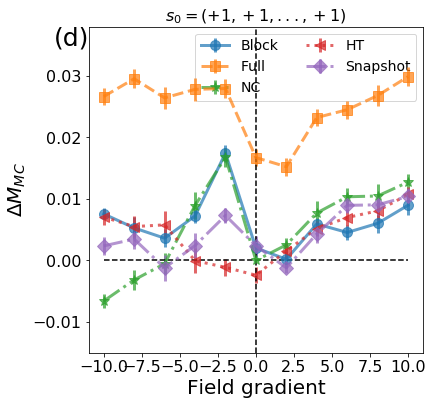

In [5]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    
    if label=='sv':
        return 'HT'
    elif label=='nc':
        return 'NC'
    
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([-10,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='upper right').set_zorder(0)

#plt.xlim(-11,11)
#plt.xlim(-1,1)
#plt.xlim(-1,19)
plt.ylim(-0.015,0.038)
#plt.ylim(-0.015,0.017)
plt.plot([0,0],[-0.015,0.038],'k--')


if init_sign==-1.0:
    plt.text(-13.3,0.035,'(c)',fontsize=25)
    plt.title("$s_0=(-1,-1,...,-1)$",fontsize=16)
elif init_sign==1.0:
    plt.text(-13.3,0.035,'(d)',fontsize=25)
    plt.title("$s_0=(+1,+1,...,+1)$",fontsize=16)

plt.savefig(f"Plots/Pokec_markup_as_grad_beta_{beta_choice}_{init_sign}".replace('.','-') + ".jpg",bbox_inches='tight')

In [6]:
single_gradient=eval_data.loc[eval_data['gradient']==0]
single_gradient

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient,Sample_index
1050,0,no con,0.683415,0.000017,8.0,0.0,8.0
1051,1,unif,0.697005,0.000020,8.0,0.0,8.0
1052,2,full,0.717132,0.000007,8.0,0.0,8.0
1053,3,block,0.696059,0.000008,8.0,0.0,8.0
1054,4,sv,0.694524,0.000013,8.0,0.0,8.0
...,...,...,...,...,...,...,...
1150,2,full,0.712104,0.000016,8.0,0.0,7.0
1151,3,block,0.707241,0.000011,8.0,0.0,7.0
1152,4,sv,0.700900,0.000007,8.0,0.0,7.0
1153,5,nc,0.000283,0.000024,8.0,0.0,7.0


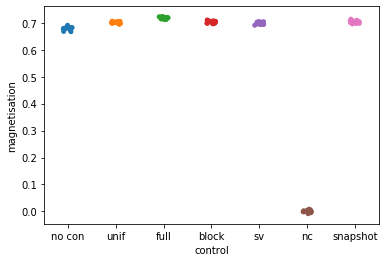

In [7]:
sns.stripplot(data=single_gradient,x='control',y='magnetisation')

In [8]:
np.arange(12.0,19.0,1.0)

array([12., 13., 14., 15., 16., 17., 18.])

## Fraction of full-mf markup

(array([-12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,
         10. ,  12.5]), <a list of 11 Text xticklabel objects>)

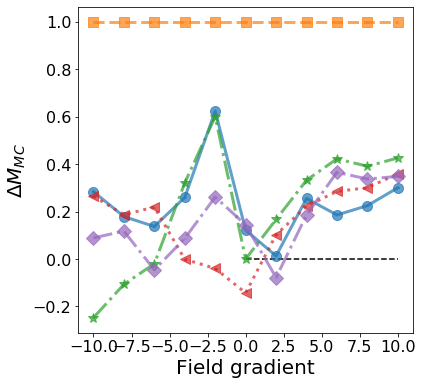

In [9]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    mf_full_markup = list(grouped[f'markup_full_mean'])
    
    mean_markup=[i/j for i,j in zip(mean_markup,mf_full_markup)]
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([0,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

## As a fraction above unif

In [10]:
beta_choice = 8.0 #8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = (pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif'])/abs(pivotted['magnetisation_unif'])

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_block_mean,markup_block_sem,markup_full_mean,markup_full_sem,markup_nc_mean,markup_nc_sem,markup_sv_mean,markup_sv_sem,markup_snapshot_mean,markup_snapshot_sem
0,8.0,-10.0,0.038489,0.004634,0.135265,0.007303,-0.033197,0.005901,0.036002,0.006648,0.012318,0.007178
1,8.0,-8.0,0.025288,0.008299,0.138805,0.008144,-0.014333,0.007591,0.026353,0.008160,0.016826,0.007569
2,8.0,-6.0,0.013963,0.005596,0.099607,0.007222,-0.001713,0.006352,0.022198,0.008164,-0.004075,0.008083
3,8.0,-4.0,0.019171,0.003008,0.073642,0.005089,0.023811,0.005828,0.000131,0.005221,0.006624,0.005446
4,8.0,-2.0,0.031734,0.002574,0.050819,0.002905,0.030509,0.002761,-0.002014,0.002516,0.013295,0.002347


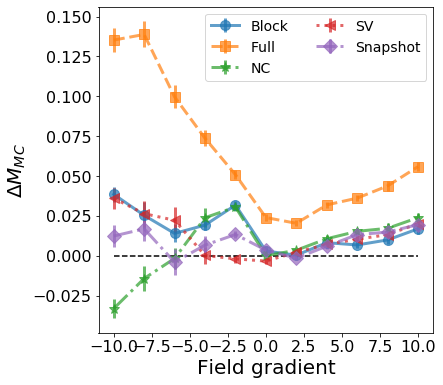

In [11]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([-10,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='upper right').set_zorder(0)
plt.savefig(f"Plots/FractionalPokec_markup_as_grad_beta_{beta_choice}_{init_sign}".replace('.','-') + ".jpg",bbox_inches='tight')